In [31]:
import sys
import os

import pandas as pd
import numpy as np
from numpy import array
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

# Load in Data

In [32]:
df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
df_coarse = pd.read_csv("../../dat/Final_Data_Beth.csv")

df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# add dive duration
coarse_features = ['diveDuration']

df = df.merge(df_coarse[['divenum']+coarse_features],
              on = 'divenum',
              how = 'left')

for feature in coarse_features:
    df.loc[df.duplicated(['ID','divenum']),feature] = np.nan

df["w_low"] = np.log(df["w_low"])
df["w_high"] = np.log(df["w_high"])
#df['diveDuration'] = np.exp(df['diveDuration'])

df["delt_d"] = df["ad"].diff()
df["elev"] = -df["ad"]

df = df[df["ID"] == "D26"]
df = df.reset_index()

#jump_inds = range(len(df))
jump_inds = df.index[~np.isnan(df["diveDuration"])].to_list()

# make the delta_d nan at the start of each dive
df["delt_d"].iloc[jump_inds] = np.nan

# add edives to df
edives = [False]*len(df)
for ind in jump_inds[1:]:
    if ind-1 not in jump_inds[1:]:
        edives[ind-1] = True
edives[-1] = True
df["e_dive"] = edives

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_3486/1774815403.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_3486/1774815403.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delt_d"].iloc[jump_inds] = np.nan


In [33]:
# populate a data object
data = []

initial_ts = [0]
final_ts = []

features = ['delt_d','e_dive']#'diveDuration','aw1','aw2','aw3','w_low']

means = {feature: df[feature].mean() for feature in features}
stds = {feature: df[feature].std() for feature in features}

for feature in ['delt_d']:#['aw1','aw2','aw3']:
    df[feature] = (df[feature] - means[feature])/stds[feature]

#for feature in ['diveDuration','w_low']:
#    df[feature] = df[feature]/stds[feature]

for t,row in enumerate(df.iterrows()):
    
    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)
     
    data.append({feature : row[1][feature] for feature in features})

final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

print(initial_ts)
print(final_ts)

[0]
[9566]


In [34]:
data

[{'delt_d': nan, 'e_dive': False},
 {'delt_d': 2.963890539668026, 'e_dive': False},
 {'delt_d': 2.858747764135668, 'e_dive': False},
 {'delt_d': 2.4865237179511466, 'e_dive': False},
 {'delt_d': 1.4201828487774386, 'e_dive': False},
 {'delt_d': 0.7731658297310671, 'e_dive': False},
 {'delt_d': 0.47972500972511845, 'e_dive': False},
 {'delt_d': 0.49889629245136713, 'e_dive': False},
 {'delt_d': 0.522973237939559, 'e_dive': False},
 {'delt_d': 0.8139399541411055, 'e_dive': False},
 {'delt_d': -1.2277353442635905, 'e_dive': False},
 {'delt_d': -1.6598868088682435, 'e_dive': False},
 {'delt_d': -1.698778062344215, 'e_dive': False},
 {'delt_d': -1.9870254459643566, 'e_dive': False},
 {'delt_d': -1.6827141353610415, 'e_dive': False},
 {'delt_d': -1.2188083232359819, 'e_dive': False},
 {'delt_d': -0.5466935788532746, 'e_dive': False},
 {'delt_d': -0.3125815226948125, 'e_dive': False},
 {'delt_d': -0.4567532417821954, 'e_dive': False},
 {'delt_d': -0.5380975677550454, 'e_dive': False},
 {'delt

# Plot Data

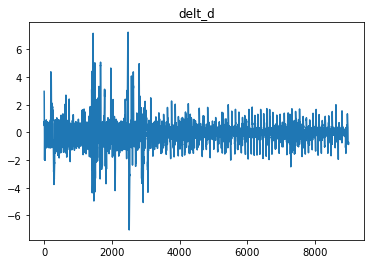

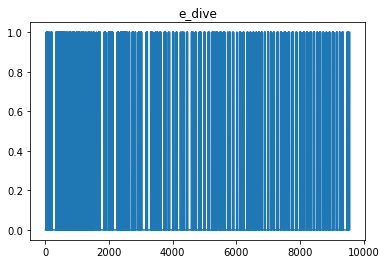

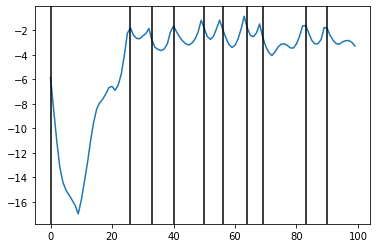

In [35]:
for feature in features:
    plt.plot([datum[feature] for datum in data if not np.isnan(datum[feature])])
    plt.title(feature)
    plt.show()
    
df["elev"].iloc[0:100].plot()

for ind in jump_inds:
    if ind < 100:
        plt.axvline(ind,color='k')

# Initialize HMM

In [36]:
importlib.reload(HHMM)
importlib.reload(optimizor)
importlib.reload(stoch_optimizor)

K = [3,3]
T = len(data)

### pick distributions ###
features = {'delt_d'     : {'f'           : 'normal',
                            'lower_bound' : None,
                            'upper_bound' : None,
                            'share_coarse': False,
                            'share_fine'  : False},
            'e_dive'     : {'f'           : 'bern',
                            'lower_bound' : None,
                            'upper_bound' : None,
                            'share_coarse': False,
                            'share_fine'  : False}}

In [37]:
'''
# shared parameters
share_params = []

# share coarse scale dive duration
for feature in ['delt_d']:
    for param in ['log_mu','log_sig']:
        for k0 in range(K[0]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0],
                                 "K_fine"  :[k1 for k1 in range(K[1])]})

# share fine scale acceleration
for feature in ['aw1','aw2','aw3']:
    for param in ['log_mu','log_sig']:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0 for k0 in range(K[0])],
                                 "K_fine"  :[k1]})
# share autocorrelation for acceleration
for k1 in range(K[1]):
    share_params.append({"features":['aw1','aw2','aw3'],
                         "params"  :['logit_phi'],
                         "K_coarse":[k0 for k0 in range(K[0])],
                         "K_fine"  :[k1]})
            
# share params for "w_low"
for feature in ['w_low']:
    for param in ["mu","log_sig"]:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0 for k0 in range(K[0])],
                                 "K_fine"  :[k1]})
'''

# shared parameters
share_params = []

# share fine-scale params delta-d
#for feature in ['delt_d']:
#    for param in ['mu','log_sig']:
#        for k1 in range(K[1]):
#            share_params.append({"features":[feature],
#                                 "params"  :[param],
#                                 "K_coarse":[k0 for k0 in range(K[0])],
#                                 "K_fine"  :[k1]})

# share coarse scale dive duration
for feature in ['delt_d']:
    for param in ['mu','log_sig']:
        for k0 in range(K[0]):
            for k1 in range(K[1]):
                share_params.append({"features":[feature],
                                     "params"  :[param],
                                     "K_coarse":[k0],
                                     "K_fine"  :[k1]})
                
for feature in ['e_dive']:
    for param in ['logit_p']:
        for k0 in range(K[0]):
            for k1 in range(K[1]):
                share_params.append({"features":[feature],
                                     "params"  :[param],
                                     "K_coarse":[k0],
                                     "K_fine"  :[k1]})

In [38]:
fix_theta = [{'delt_d': {'mu': array([None, None, None], dtype=object),
                         'log_sig': array([None, None, None], dtype=object)},
              'e_dive': {'logit_p': array([-100, -100,  None], dtype=object)}},
             {'delt_d': {'mu': array([None, None, None], dtype=object),
                         'log_sig': array([None, None, None], dtype=object)},
              'e_dive': {'logit_p': array([-100, -100,  None], dtype=object)}},
             {'delt_d': {'mu': array([None, None, None], dtype=object),
                         'log_sig': array([None, None, None], dtype=object)},
              'e_dive': {'logit_p': array([-100, -100,  None], dtype=object)}}]

fix_eta = [array([[ 0.0, None, None],
                  [None,  0.0, None],
                  [None, None,  0.0]], dtype=object),
           [array([[ 0.0, None, None],
                   [-100,  0.0, None],
                   [-100, -100,  0.0]], dtype=object),
            array([[ 0.0, None, None],
                   [-100,  0.0, None],
                   [-100, -100,  0.0]], dtype=object),
            array([[ 0.0, None, None],
                   [-100,  0.0, None],
                   [-100, -100,  0.0]], dtype=object)]]

fix_eta0 = [array([ 0.0, None, None], dtype=object),
            [array([ 0.0, -100, -100], dtype=object),
             array([ 0.0, -100, -100], dtype=object),
             array([ 0.0, -100, -100], dtype=object)]]

In [39]:
importlib.reload(HHMM)
importlib.reload(optimizor)
importlib.reload(stoch_optimizor)

# pick intial parameters
optim = stoch_optimizor.StochOptimizor(data,features,share_params,K,
                                       fix_theta=fix_theta,
                                       fix_eta=fix_eta,
                                       fix_eta0=fix_eta0)

optim.initial_ts = initial_ts
optim.final_ts = final_ts
optim.jump_inds = jump_inds

optim.theta = [{'delt_d': {'mu': array([ 1.0, 0.0,  -1.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])},
                'e_dive': {'logit_p': array([-100, -100,  -1.0])}},
               {'delt_d': {'mu': array([ 2.0, 0.0,  -2.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])},
                'e_dive': {'logit_p': array([-100, -100,  -1.0])}},
               {'delt_d': {'mu': array([ 2.0, 0.0,  -2.0]),
                           'log_sig': array([ -1.0, -1.0, -1.0])},
                'e_dive': {'logit_p': array([-100, -100,  -1.0])}}]

optim.eta = [array([[ 0. , -1.0, -1.0],
                    [-1.0,  0. , -1.0],
                    [-1.0, -1.0,  0. ]]),
             [array([[ 0.0  , -2.0  , -4.0],
                     [-100.0, 0.0   , -2.0  ],
                     [-100.0, -100.0, 0.0   ]]),
              array([[ 0.0  , -2.0  , -4.0],
                     [-100.0, 0.0   , -2.0  ],
                     [-100.0, -100.0, 0.0   ]]),
              array([[ 0.0  , -2.0  , -2.0],
                     [-100.0, 0.0   , -2.0  ],
                     [-100.0, -100.0, 0.0   ]])]]

optim.eta0 = [array([0.0, 0.0, 0.0]),
             [array([0.0 , -100.0, -100.0]),
              array([0.0 , -100.0, -100.0]),
              array([0.0 , -100.0, -100.0])]]


optim.get_log_Gamma(jump=False)
optim.get_log_Gamma(jump=True)
optim.get_log_delta()

# print initial parameters
print("initial theta:")
for theta_i in optim.theta:
    for feature in theta_i:
        print(feature)
        print(theta_i[feature])
        print("")
    print("")
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")

initial theta:
delt_d
{'mu': array([ 1.,  0., -1.]), 'log_sig': array([-1., -1., -1.])}

e_dive
{'logit_p': array([-100., -100.,   -1.])}


delt_d
{'mu': array([ 2.,  0., -2.]), 'log_sig': array([-1., -1., -1.])}

e_dive
{'logit_p': array([-100., -100.,   -1.])}


delt_d
{'mu': array([ 2.,  0., -2.]), 'log_sig': array([-1., -1., -1.])}

e_dive
{'logit_p': array([-100., -100.,   -1.])}



initial eta0:
[array([0., 0., 0.]), [array([   0., -100., -100.]), array([   0., -100., -100.]), array([   0., -100., -100.])]]

initial eta:
[array([[ 0., -1., -1.],
       [-1.,  0., -1.],
       [-1., -1.,  0.]]), [array([[   0.,   -2.,   -4.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]]), array([[   0.,   -2.,   -4.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]]), array([[   0.,   -2.,   -2.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]])]]



# Define Optimization Parameters

In [40]:
# parse command-line args
max_time = 60*60
id = 7

method_partialEs = [("control",0.0),
                    ("BFGS",0.0),
                    ("CG",0.0),
                    ("GD",0.0),
                    ("SAGA",0.0),
                    ("SAGA",0.5),
                    ("SAGA",1.0),
                    ("SVRG",0.0),
                    ("SVRG",0.5),
                    ("SVRG",1.0)]

rand_seed = [0,1,2,3,4,5,6,7,8,9]

# set methods
for i,settings0 in enumerate(product(rand_seed,method_partialEs)):
    if i == id:
        settings = settings0
        break

rand_seed = settings[0]
method = settings[1][0]
partial_E = settings[1][1]

random.seed(rand_seed)
np.random.seed(rand_seed)

print("method: %s" % method)
print("partial E_step: %.1f" % partial_E)
print("random seed: %d" % rand_seed)
print("max time : %.3f hours" % (max_time/3600))

# select parameters for optimization
num_epochs = 1000
tol = 1e-5
grad_tol = 1e-5

step_sizes = {"EM"  : [None,None],
              "CG"  : [None,None],
              "BFGS": [None,None],
              "GD"  : [0.005,0.005],
              "SGD" : [0.005,0.005],
              "SAG" : [0.005,0.005],
              "SVRG": [0.005,0.005],
              "SAGA": [0.005,0.005]}

### checks on optimization parameters ###
if partial_E > 0 and method in ["EM","BFGS","Nelder-Mead","CG"]:
    raise("partial_E not consistent with method")

### lipschitz constants ###
if method == "control":
    optim.step_size = step_sizes["SAGA"]
    if not (step_sizes["SAGA"][0] is None):
        optim.L_theta = 1.0 / step_sizes["SAGA"][0] #* np.ones(optim.K_total)
        optim.L_eta = 1.0 / step_sizes["SAGA"][1]
else:
    optim.step_size = step_sizes[method]
    if not (step_sizes[method][0] is None):
        optim.L_theta = 1.0 / (3.0 * step_sizes[method][0]) #* np.ones(optim.K_total)
        optim.L_eta = 1.0 / (3.0 * step_sizes[method][1])

method: SVRG
partial E_step: 0.0
random seed: 0
max time : 1.000 hours


In [41]:
optim.fix_eta0

[array([0.0, None, None], dtype=object),
 [array([0.0, -100, -100], dtype=object),
  array([0.0, -100, -100], dtype=object),
  array([0.0, -100, -100], dtype=object)]]

# Train the HMM

In [42]:
grad_buffer = "none"
weight_buffer = "none"

# print initial parameters
print("initial theta:")
print(optim.theta)
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")
print("parameter bounds:")
print(optim.param_bounds)
print("")
print("length of data:")
print(T)
print("")

# get optimal value via SAGA:
if method == "control":
    optim.train_HHMM_stoch(num_epochs=2*num_epochs,
                         max_time=max_time,
                         method="SAGA",
                         max_epochs=1,
                         partial_E=True,
                         tol=1e-4*tol,
                         grad_tol=1e-4*grad_tol,
                         record_like=True,
                         weight_buffer=weight_buffer,
                         grad_buffer=grad_buffer,
                         buffer_eps=1e-3)

elif partial_E == 0:
    optim.train_HHMM_stoch(num_epochs=num_epochs,
                          max_time=max_time,
                          method=method,
                          max_epochs=1,
                          partial_E=False,
                          tol=tol,
                          grad_tol=grad_tol,
                          record_like=True,
                          weight_buffer=weight_buffer,
                          grad_buffer=grad_buffer,
                          buffer_eps=1e-3)

elif partial_E == 0.5:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                              max_time=max_time,
                              method=method,
                              max_epochs=1,
                              partial_E=True,
                              tol=tol,
                              grad_tol=grad_tol,
                              record_like=True,
                              weight_buffer=weight_buffer,
                              grad_buffer=grad_buffer,
                              buffer_eps=1e-3)

elif partial_E == 1:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                               max_time=max_time,
                               method=method,
                               max_epochs=10,
                               partial_E=True,
                               tol=tol,
                               grad_tol=grad_tol,
                               record_like=True,
                               weight_buffer=weight_buffer,
                               grad_buffer=grad_buffer,
                               buffer_eps=1e-3)

initial theta:
[{'delt_d': {'mu': array([ 1.,  0., -1.]), 'log_sig': array([-1., -1., -1.])}, 'e_dive': {'logit_p': array([-100., -100.,   -1.])}}, {'delt_d': {'mu': array([ 2.,  0., -2.]), 'log_sig': array([-1., -1., -1.])}, 'e_dive': {'logit_p': array([-100., -100.,   -1.])}}, {'delt_d': {'mu': array([ 2.,  0., -2.]), 'log_sig': array([-1., -1., -1.])}, 'e_dive': {'logit_p': array([-100., -100.,   -1.])}}]

initial eta0:
[array([0., 0., 0.]), [array([   0., -100., -100.]), array([   0., -100., -100.]), array([   0., -100., -100.])]]

initial eta:
[array([[ 0., -1., -1.],
       [-1.,  0., -1.],
       [-1., -1.,  0.]]), [array([[   0.,   -2.,   -4.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]]), array([[   0.,   -2.,   -4.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]]), array([[   0.,   -2.,   -2.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]])]]

parameter bounds:
{'delt_d': {'mu': [nan, nan], 'log_sig': [-5.0, 2.659242788894192]}, 'e_d

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/helper_funcs.py:109: RuntimeWarning: divide by zero encountered in log
  np.log(C, out=C)


...done

current parameters:
[{'delt_d': {'mu': array([ 1.,  0., -1.]), 'log_sig': array([-1., -1., -1.])}, 'e_dive': {'logit_p': array([-100., -100.,   -1.])}}, {'delt_d': {'mu': array([ 2.,  0., -2.]), 'log_sig': array([-1., -1., -1.])}, 'e_dive': {'logit_p': array([-100., -100.,   -1.])}}, {'delt_d': {'mu': array([ 2.,  0., -2.]), 'log_sig': array([-1., -1., -1.])}, 'e_dive': {'logit_p': array([-100., -100.,   -1.])}}]
[array([[ 0., -1., -1.],
       [-1.,  0., -1.],
       [-1., -1.,  0.]]), [array([[   0.,   -2.,   -4.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]]), array([[   0.,   -2.,   -4.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]]), array([[   0.,   -2.,   -2.],
       [-100.,    0.,   -2.],
       [-100., -100.,    0.]])]]
[array([0., 0., 0.]), [array([   0., -100., -100.]), array([   0., -100., -100.]), array([   0., -100., -100.])]]

table averages:
[{'delt_d': {'mu': array([-1445.62020376,  1565.81089093,  1765.39992324]), 'log_sig': arr

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/stoch_optimizor.py:1138: RuntimeWarning: invalid value encountered in double_scalars
  elif ((ll_new - ll_old)/np.abs(ll_old)) < tol:
/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/stoch_optimizor.py:206: RuntimeWarning: invalid value encountered in multiply
  G_t_new = -np.sum(np.nan_to_num(self.p_Xtm1_Xt[t] * self.get_log_Gamma(eta=eta_new,eta0=eta0_new,jump=False)))
/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/stoch_optimizor.py:207: RuntimeWarning: invalid value encountered in multiply
  G_t  = -np.sum(np.nan_to_num(self.p_Xtm1_Xt[t] * self.get_log_Gamma(eta=self.eta,eta0=self.eta0,jump=False)))


M-step failed to converge: maximum number of iterations reached
...done

L_theta:  139.0053042007964
alpha_theta:  0.0023979900281490382
L_eta:  34.885191864624595
alpha_eta:  0.009555152645479664


starting epoch 2.0

0.004 hours elapsed

starting E-step...
...done

current parameters:
[{'delt_d': {'mu': array([ 0.82025752,  0.04630848, -0.8164227 ]), 'log_sig': array([-0.89212154, -1.24700352, -0.9468894 ])}, 'e_dive': {'logit_p': array([-100.        , -100.        ,   -0.72733288])}}, {'delt_d': {'mu': array([ 2.34474299, -0.01753302, -2.42133487]), 'log_sig': array([ 0.1801392 , -0.43188617,  0.28743327])}, 'e_dive': {'logit_p': array([-100.        , -100.        ,   -1.12675803])}}, {'delt_d': {'mu': array([ 2.13677562, -0.02912531, -2.05982154]), 'log_sig': array([-0.55424399, -0.85693568, -0.69156968])}, 'e_dive': {'logit_p': array([-100.        , -100.        ,   -1.01306519])}}]
[array([[ 0.        , -1.58710823, -1.63584323],
       [-0.92949392,  0.        , -1.02125078],
  

M-step failed to converge: maximum number of iterations reached
...done

L_theta:  78.7552082953668
alpha_theta:  0.004232524305988579
L_eta:  5.142496301229205
alpha_eta:  0.06481936277789001


starting epoch 8.0

0.062 hours elapsed

starting E-step...
...done

current parameters:
[{'delt_d': {'mu': array([ 0.65264909,  0.04615976, -0.68029122]), 'log_sig': array([-1.09341483, -1.55507252, -1.00042225])}, 'e_dive': {'logit_p': array([-100.        , -100.        ,   -0.64790361])}}, {'delt_d': {'mu': array([ 2.1895331 ,  0.0910486 , -2.34760228]), 'log_sig': array([ 0.68809299, -0.07852968,  0.48223843])}, 'e_dive': {'logit_p': array([-100.        , -100.        ,   -1.86954618])}}, {'delt_d': {'mu': array([ 1.76141079,  0.02762795, -1.42181454]), 'log_sig': array([-0.35471671, -0.71457234, -0.92184291])}, 'e_dive': {'logit_p': array([-100.        , -100.        ,   -1.22215417])}}]
[array([[ 0.00000000e+00, -3.41500112e+00, -3.04758182e+00],
       [-2.74428909e-01,  0.00000000e+00, 

M-step failed to converge: maximum number of iterations reached
...done

L_theta:  44.6197565575419
alpha_theta:  0.0074705323168553096
L_eta:  0.761644531746346
alpha_eta:  0.43764948009151444


starting epoch 14.0

0.118 hours elapsed

starting E-step...
...done

current parameters:
[{'delt_d': {'mu': array([ 0.60899926,  0.03703668, -0.66270544]), 'log_sig': array([-1.15628042, -1.68323725, -1.03177239])}, 'e_dive': {'logit_p': array([-100.        , -100.        ,   -0.59553696])}}, {'delt_d': {'mu': array([ 2.31751592,  0.27607418, -2.35288948]), 'log_sig': array([ 0.74238667, -0.03580731,  0.45761418])}, 'e_dive': {'logit_p': array([-100.        , -100.        ,   -2.28935171])}}, {'delt_d': {'mu': array([ 1.398441  ,  0.03388744, -1.26120954]), 'log_sig': array([-0.51331761, -0.8591839 , -0.94485846])}, 'e_dive': {'logit_p': array([-100.        , -100.        ,   -1.48443797])}}]
[array([[ 0.        , -3.89174187, -2.71090287],
       [ 1.34887251,  0.        , -1.72658708],
    

KeyboardInterrupt: 

# Save the HMM

In [ ]:
optim.fix_theta

In [ ]:
optim.theta

In [ ]:
date_today = datetime.today().strftime('%Y-%m-%d')

In [ ]:
file = "case_study_updown_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)

if not os.path.isdir("../params/case_study/updown/"):
    os.mkdir("../params/case_study/updown/")
    
if not os.path.isdir("../params/case_study/updown/" + date_today):
    os.mkdir("../params/case_study/updown/" + date_today)

with open("../params/case_study/updown/" + date_today + "/" + file, 'wb') as f:
    pickle.dump(optim, f)

In [ ]:
x = []
y = []
for theta in optim.theta_trace:
    x.append(theta[0]['delt_d']['mu'])
    y.append(theta[0]['delt_d']['log_sig'])
    
plt.plot(x)
plt.show()
plt.plot(y)
plt.show()

In [ ]:
#x = []
y = []
z = []
for eta in optim.eta_trace:
    #x.append(eta[0].flatten())
    y.append(eta[1][0].flatten())
    z.append(eta[1][1].flatten())
    
#plt.plot(x)
plt.plot(y)
plt.ylim([-5,5])
plt.show()

plt.plot(z)
plt.ylim([-5,5])
plt.show()

In [ ]:
self = optim

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# define colors
coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

K_total = self.K[1]*self.K[0]
perc = 0.95

fig,ax = plt.subplots(1,len(self.features)+1,figsize=(10,3))

x_labels = {"diveDuration" : "Dive Duration (s)",
            "maxDepth"     : "Maximum Depth (m)",
            "avg_bot_htv"  : "Average Bottom RHTV (rad/s)",
            "postDiveInt"  : "Post Dive Interval (seconds)",
            "w_low"        : "Wiggliness (low feq)",
            "w_high"       : "Wiggliness (high freq)",
            "delt_d"       : "Change in Depth"}

for fignum,feature in enumerate(['delt_d']):#enumerate(self.features):
    
    # get bounds
    min_mu = np.min([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_mu = np.max([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_sig = np.exp(np.max([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))
    
    x = np.linspace(min_mu-3*max_sig,max_mu+3*max_sig,1000)
    
    # see if we are using a truncnorm
    a = self.features[feature]["lower_bound"]
    b = self.features[feature]["upper_bound"]
    if not a is None:
        a = np.concatenate([self.features[feature]["lower_bound"] for _ in self.theta])
    if not b is None:
        b = np.concatenate([self.features[feature]["upper_bound"] for _ in self.theta])

    # now get the y values for each x
    y0 = np.zeros((1000,K_total))

    # true ys
    mu = np.concatenate([theta_fine[feature]['mu'] for theta_fine in self.theta])
    sig = np.exp(np.concatenate([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))

    for state in range(K_total):
        if (not a is None) and (not b is None):
            y0[:,state] = truncnorm.pdf(x,a=(a[state]-mu[state])/sig[state],
                                          b=(b[state]-mu[state])/sig[state],
                                          loc=mu[state],scale=sig[state])
        else:
            y0[:,state] = norm.pdf(x,mu[state],sig[state])
    
    if feature == "maxDepth":
        ax[fignum].axvline(np.log(20),color='k',linestyle='--')
        ax[fignum].axvline(np.log(5),color='k',linestyle='--')
    
    for fignum,k0 in enumerate(range(self.K[0])):
        for k1 in range(self.K[1]):

            # define state:
            state = fignum*self.K[1] + k1
            
            # plot distribution
            ax[fignum].plot(x,y0[:,state],
                            color=fine_colors[k1])
        
    # add labels
    if fignum == 0:
        ax[fignum].set_ylabel("Probability Density")

    ax[fignum].set_xlabel(x_labels[feature])
    #ax[fignum].set_xscale('log')
        
leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])]

legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                   markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])]

fig.legend(handles=legend_elements,prop={'size': 10}, ncol=self.K[1], mode="expand", borderaxespad=0.,
             bbox_to_anchor=(0.1, 0.9, 0.8, .1), loc='lower left')

# Unit Tests

In [20]:
optim.E_step()

/Users/evsi8432/Documents/Research/sublinear-HMM-inference/src/helper_funcs.py:109: RuntimeWarning: divide by zero encountered in log
  np.log(C, out=C)


In [21]:
delta = 0.00001

ll0 = optim.get_log_like()

optim.eta[1][1][1,2] += delta
optim.get_log_Gamma(jump=True)
optim.get_log_Gamma(jump=False)
optim.get_log_delta()

ll1 = optim.get_log_like()

optim.eta[1][1][1,2] -= delta
optim.get_log_Gamma(jump=True)
optim.get_log_Gamma(jump=False)
optim.get_log_delta()

print((ll1 - ll0) / delta)

print(optim.grad_eta[1][1][1,2])

6.137231230241013
6.137625810673655


In [22]:
optim.eta

[array([[ 0.        , -1.15460287, -3.17387208],
        [ 1.52207339,  0.        , -1.86816819],
        [ 0.27247874, -1.24441617,  0.        ]]),
 [array([[   0.        ,   -0.58397078,   -4.29461827],
         [-100.        ,    0.        ,   -0.59398011],
         [-100.        , -100.        ,    0.        ]]),
  array([[   0.        ,   -2.1690675 ,   -4.55637902],
         [-100.        ,    0.        ,   -3.31406028],
         [-100.        , -100.        ,    0.        ]]),
  array([[   0.        ,   -3.12340115,   -4.03133711],
         [-100.        ,    0.        ,   -3.57356305],
         [-100.        , -100.        ,    0.        ]])]]

In [23]:
optim.eta0

[array([ 0.        , -0.03826603,  0.07689732]),
 [array([   0., -100., -100.]),
  array([   0., -100., -100.]),
  array([   0., -100., -100.])]]

In [24]:
optim.log_Gamma_jump

array([[  -0.30529403, -100.30529403, -100.30529403,   -1.4598969 ,
        -101.4598969 , -101.4598969 ,   -3.47916611, -103.47916611,
        -103.47916611],
       [  -0.30529403, -100.30529403, -100.30529403,   -1.4598969 ,
        -101.4598969 , -101.4598969 ,   -3.47916611, -103.47916611,
        -103.47916611],
       [  -0.30529403, -100.30529403, -100.30529403,   -1.4598969 ,
        -101.4598969 , -101.4598969 ,   -3.47916611, -103.47916611,
        -103.47916611],
       [  -0.22470986, -100.22470986, -100.22470986,   -1.74678325,
        -101.74678325, -101.74678325,   -3.61495144, -103.61495144,
        -103.61495144],
       [  -0.22470986, -100.22470986, -100.22470986,   -1.74678325,
        -101.74678325, -101.74678325,   -3.61495144, -103.61495144,
        -103.61495144],
       [  -0.22470986, -100.22470986, -100.22470986,   -1.74678325,
        -101.74678325, -101.74678325,   -3.61495144, -103.61495144,
        -103.61495144],
       [  -0.68354204, -100.68354204, -1

In [25]:
delta = 0.00001

Gamma0 = optim.log_Gamma_jump[3,0]

optim.eta[0][1,0] += delta
optim.get_log_Gamma(jump=True)
optim.get_log_Gamma(jump=False)
optim.get_log_delta()

Gamma1 = optim.log_Gamma_jump[3,0]

optim.eta[0][1,0] -= delta
optim.get_log_Gamma(jump=True)
optim.get_log_Gamma(jump=False)
optim.get_log_delta()

print((Gamma1 - Gamma0) / delta)

grad_eta0_log_delta,grad_eta_log_Gamma = optim.get_grad_log_Gamma(jump=True)

print(grad_eta_log_Gamma[0][1,0,1,0])

0.201251259945856
0.20125206368800286


In [26]:
optim.grad_eta

[array([[  0.        , -13.41846359,   2.81868895],
        [  1.01627199,   0.        ,  -1.12598232],
        [  7.68955115,  -1.52384184,   0.        ]]),
 [array([[ 0.        ,  2.8394417 , -0.86624082],
         [ 0.        ,  0.        , -2.9538758 ],
         [ 0.        ,  0.        ,  0.        ]]),
  array([[ 0.        , -2.75341155, -3.37837283],
         [ 0.        ,  0.        ,  6.13762581],
         [ 0.        ,  0.        ,  0.        ]]),
  array([[ 0.        ,  0.22811753, -4.84807082],
         [ 0.        ,  0.        ,  1.79454541],
         [ 0.        ,  0.        ,  0.        ]])]]

In [27]:
date_today

'2023-04-09'